In [1]:
import argparse
import os
import numpy as np
import torch as th
from guided_diffusion import dist_util
from guided_diffusion.script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    args_to_dict,
    add_dict_to_argparser,
)
from tqdm import tqdm
from guided_diffusion.image_datasets import load_data

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from torchvision import utils
import math

# Load model

In [2]:
sample_dict = dict(clip_denoised=True, alpha=1.0, num_steps=1000,
                   batch_size=1, down_N=32, range_t=20,
                   use_ddim=False, base_samples="./ref_imgs/face",
                   model_path="./models/ffhq_10m.pt", 
                   save_dir="./output", save_latents=False)

defaults = model_and_diffusion_defaults()
defaults['diffusion_steps'] = sample_dict['num_steps']
model, diffusion = create_model_and_diffusion(**defaults)
model.load_state_dict(dist_util.load_state_dict(sample_dict['model_path'], map_location="cpu"))
model = model.to(dist_util.dev())
model = model.eval()
print(diffusion.num_timesteps)
print(diffusion.model_mean_type, diffusion.model_var_type)

1000
ModelMeanType.EPSILON ModelVarType.LEARNED_RANGE


# Setup dataloader

In [3]:
def load_reference(data_dir, batch_size, image_size, class_cond=False):
    data = load_data(
        data_dir=data_dir,
        batch_size=batch_size,
        image_size=image_size,
        class_cond=class_cond,
        deterministic=True,
        random_flip=False,
    )
    for large_batch, model_kwargs in data:
        model_kwargs["ref_img"] = large_batch
        yield model_kwargs

data = load_reference(sample_dict['base_samples'],
                      sample_dict['batch_size'],
                      image_size=defaults['image_size'],
                      class_cond=defaults['class_cond'])

In [13]:
M = th.tensor([[5.7735014e-01, -8.1649649e-01, 4.7008697e-08],
               [5.7735026e-01, 4.0824834e-01, 7.0710671e-01],
               [5.7735026e-01, 4.0824822e-01, -7.0710683e-01]])
# `invM` is the inverse transformation of `M`
invM = th.inverse(M)

# Decouple a gray-scale image with `M`
def decouple(inputs):
    return th.einsum('bihw,ij->bjhw', inputs, M.to(inputs.device))

# The inverse function to `decouple`.
def couple(inputs):
    return th.einsum('bihw,ij->bjhw', inputs, invM.to(inputs.device))

def get_mask(image):
    mask = th.cat([th.ones_like(image[:, :1, ...]), th.zeros_like(image[:, 1:, ...])], dim=1)
    return mask

def reconstruct_mcg(diffusion_model, diffusion_process, y_grey, var_dict, tau=1.0):
    l = []
    indices = list(range(var_dict['num_steps']))[::-1]
    xt = th.randn(y_grey.shape, dtype=y_grey.dtype, 
                  device=y_grey.device,
                  requires_grad=True)/np.sqrt(tau)
    B, C = xt.shape[:2]
    color_mask = get_mask(y_grey)
    
    for i in tqdm(indices):
        t = th.tensor([i], device=xt.device)
        
        with th.no_grad():
            
            rho = diffusion_process.sqrt_alphas_cumprod[t]
            labda = diffusion_process.sqrt_one_minus_alphas_cumprod[t]

            with th.enable_grad():
                # inpainting algorithm
                xt = xt.requires_grad_(True)
                sample_dict = diffusion_process.p_mean_variance(diffusion_model, xt, t)

                x0_hat =  sample_dict['pred_xstart']
                x0_hat_inpainted = color_mask * decouple(x0_hat)
                
                mcg = (couple(color_mask*decouple(y_grey) - x0_hat_inpainted)).pow(2).mean()#.sum()/256/256*100*100
                g = th.autograd.grad(mcg, xt)[0]
            
            l.append(th.norm(g).item())
            xt_mean, xt_logvar = sample_dict['mean'], sample_dict['log_variance']
            epi_x = th.randn(xt.shape, dtype=xt.dtype, 
                             device=xt.device,
                             requires_grad=False)/np.sqrt(tau)
            xt_1_ = xt_mean + epi_x * th.exp(0.5 * xt_logvar)
            xt_1__ = xt_1_ - var_dict['alpha']*g
            
            epi_y = th.randn(xt.shape, dtype=xt.dtype, 
                             device=xt.device,
                             requires_grad=False)
            y_t = rho * decouple(y_grey)*color_mask + labda * epi_y
            xt = couple(decouple(xt_1__)*(1-color_mask) + color_mask*y_t)
    return xt, l

def reconstruct_vanilla(diffusion_model, diffusion_process, y_grey, var_dict, tau=1.0):

    indices = list(range(min(var_dict['num_steps'], 1000)))[::-1]
    xt = th.randn(y_grey.shape, dtype=y_grey.dtype, 
                  device=y_grey.device,
                  requires_grad=True)/np.sqrt(tau)
    B, C = xt.shape[:2]
    color_mask = get_mask(y_grey)
    
    for i in tqdm(indices):
        t = th.tensor([i], device=xt.device)
        
        with th.no_grad():
            
            rho = diffusion_process.sqrt_alphas_cumprod[t]*decouple(y_grey)*color_mask
            labda = diffusion_process.sqrt_one_minus_alphas_cumprod[t]
            epi = th.randn(xt.shape, dtype=xt.dtype, 
                           device=xt.device,
                           requires_grad=False)
            xt_hat = rho + epi*labda
            xt = couple(decouple(xt)*(1.-color_mask) + xt_hat*color_mask)
            
            sample_dict = diffusion_process.p_mean_variance(diffusion_model, xt, t)
            xt_mean, xt_logvar = sample_dict['mean'], sample_dict['log_variance']
            epi_x = th.randn(xt.shape, dtype=xt.dtype, 
                             device=xt.device,
                             requires_grad=False)/np.sqrt(tau)
            xt_1 = xt_mean + epi_x * th.exp(0.5*xt_logvar)
            xt = couple(decouple(xt_1)*(1.-color_mask) + decouple(y_grey)*color_mask)

    return xt


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:54<00:00,  8.75it/s]


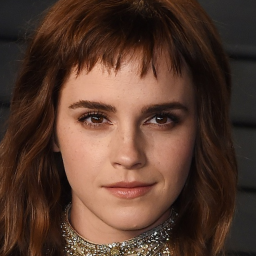

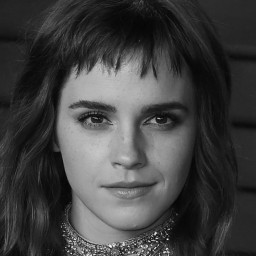

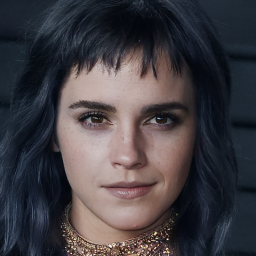

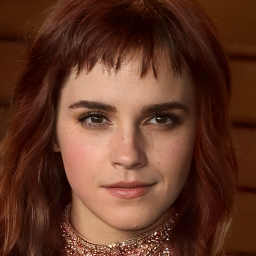

In [14]:
from IPython.display import Image, display

def save_and_display(save_path, image_data, image_type='original'):
    
    outpath = os.path.join(save_path, image_type + '.png')
    utils.save_image(image_data, outpath, nrow=1, 
                     normalize=True, range=(-1, 1))
    display(Image(filename=outpath))
    
while True:
    model_kwargs = next(data)
    model_kwargs = {k: v.to(dist_util.dev()) for k, v in model_kwargs.items()}
    
    image_ori = model_kwargs['ref_img'][0]
    image_grey = th.mean(image_ori, axis=0).repeat(3, 1, 1).unsqueeze(0)

    image_recon_v1 = reconstruct_vanilla(model, diffusion, image_grey, sample_dict)
    image_recon_v2, l = reconstruct_mcg(model, diffusion, image_grey, sample_dict)
    
    save_and_display(sample_dict['save_dir'], image_ori)
    save_and_display(sample_dict['save_dir'], image_grey, 'grey_scale')
    save_and_display(sample_dict['save_dir'], image_recon_v1, 'color_recon_v1')
    save_and_display(sample_dict['save_dir'], image_recon_v2, 'color_recon_v2')
    break